In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import tensorflow as tf
import matplotlib.image as mpimg
from PIL import Image

In [2]:
# Load the model using TensorFlow's built-in method
model = tf.keras.models.load_model("D:/PATENT/Model_testing/fibrosis_modified_model25.h5")

In [3]:
for layer in model.layers:
    print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [4]:
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [5]:
# Function to generate feature maps
def generate_feature_map(img_path):
    img = load_img(img_path, target_size=(299, 299))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get feature maps
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('conv5_block3_3_conv').output)
    intermediate_output = intermediate_layer_model.predict(x)
    
    # Plot the feature maps
    plt.figure(figsize=(16, 16))
    for i in range(10):
        plt.subplot(5, 5, i+1)
        plt.imshow(intermediate_output[0, :, :, i], cmap='viridis')
    plt.show()

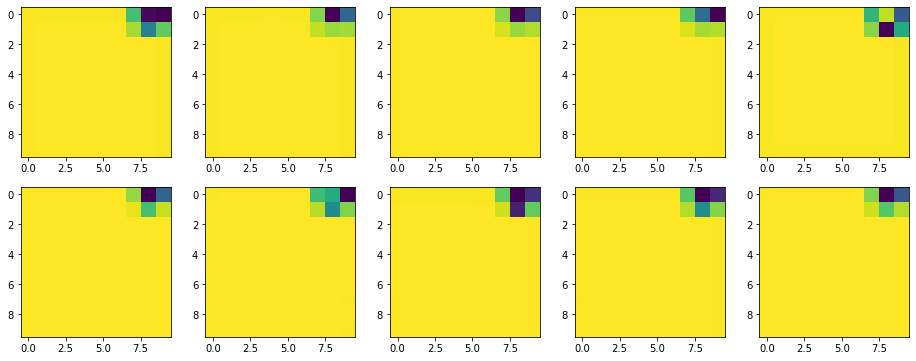

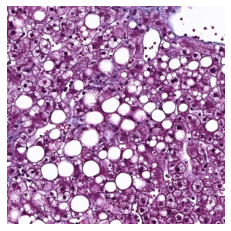

Predictions: [[5.9688926e-01 4.0139306e-01 5.0983869e-04 8.5332099e-04 3.5452703e-04]]
Blue stain area: 0.0
Predicted NASH score: 0: No fibrosis


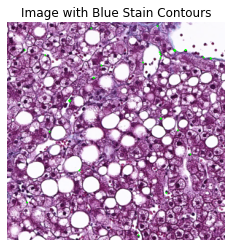

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Define lower and upper bounds for dark blue color in HSV
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 100])  # Adjust this upper bound as needed
    
    # Threshold the HSV image to get only dark blue colors
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    
    # Find contours of dark blue regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of dark blue regions and draw contours on the image
    blue_area = 0
    img_with_contours = img.copy()  # Create a copy of the original image
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)  # Draw contour on the image
    
    return blue_area, img_with_contours

# Function to make prediction on a single image
def predict_image(img_path, model):
    # Load and preprocess the image
    img = Image.open(img_path)
    #img = img.resize((299, 299))  # Resize the image
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Predict using the model
    preds = model.predict(x)
    print('Predictions:', preds)

    # Get the index of the class with maximum probability
    max_prob_index = np.argmax(preds)
    
    # Define the NASH score mapping
    nash_scores = {
        0: "0: No fibrosis",
        1: "1: Mild/moderate perisinusoidal fibrosis",
        2: "2: Periportal/portal fibrosis",
        3: "3: Bridging fibrosis",
        4: "4: Cirrhosis"
    }
    
    # Get the NASH score corresponding to the maximum probability
    nash_score = nash_scores[max_prob_index]
    
    # Calculate blue area and overlay contours on the image
    blue_area, img_with_contours = calculate_blue_area(np.array(img))
    print('Blue stain area:', blue_area)
    
    # Print the NASH score
    print('Predicted NASH score:', nash_score)
    
    # Display the image with blue contours
    plt.imshow(img_with_contours)
    plt.title('Image with Blue Stain Contours')
    plt.axis('off')
    plt.show()

# Path to the input image
img_path = "D:/PATENT/random_test_images/Fibrosis/f_0_105_22_32.jpg"

# Predict NASH score, calculate blue area, and display the image with blue contours
generate_feature_map(img_path)
show_image(img_path)
predict_image(img_path, model)

In [ ]:
# Function to crop the large image into patches of size 299x299
def crop_image(image_path, patch_size=(299, 299)):
    img = Image.open(image_path)
    width, height = img.size
    patches = []
    for x in range(0, width, patch_size[0]):
        for y in range(0, height, patch_size[1]):
            patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
            patches.append(patch)
    return patches

# Function to make prediction on a single image patch
def predict_patch(patch, model):
    x = img_to_array(patch)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    print("max predictions: ",max_prob_index)
    return max_prob_index

# Function to calculate the average NASH score
def calculate_average_nash_score(image_path, model):
    patches = crop_image(image_path)
    nash_scores = []
    for patch in patches:
        nash_score = predict_patch(patch, model)
        nash_scores.append(nash_score)
    average_nash_score = np.mean(nash_scores)
    print("Average score: ", average_nash_score)
    return int(np.round(average_nash_score, 0))

# Path to the large image
image_path = "D:/DATASET/CNN/steatosis/train/2/23_184_101.png"

# Calculate average NASH score
average_nash_score = calculate_average_nash_score(image_path, model)
    
# Define the NASH score mapping
nash_scores = {
    0: "0: No fibrosis",
    1: "1: Mild/moderate perisinusoidal fibrosis",
    2: "2: Periportal/portal fibrosis",
    3: "3: Bridging fibrosis",
    4: "4: Cirrhosis"
}
    
# Get the NASH score corresponding to the maximum probability
nash_score = nash_scores[average_nash_score]
    
# Print the NASH score
print('Predicted NASH score:', nash_score)
show_image(image_path)

In [ ]:
# Function to apply stain separation annotation
def separate_stains(image):
    # Convert RGB image to grayscale
    gray = rgb2gray(image)
    
    # Apply Otsu's thresholding to separate stains
    thresh = threshold_otsu(gray)
    blue_mask = gray < thresh
    
    # Multiply original image with the blue mask
    blue_stain = np.multiply(image, np.expand_dims(blue_mask, axis=-1))
    return blue_stain

# Function to calculate the area of dark blue stain and overlay contours on the image
def calculate_blue_area(img):
    # Convert image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Define lower and upper bounds for dark blue color in HSV
    lower_dark_blue = np.array([90, 50, 50])
    upper_dark_blue = np.array([130, 255, 100])  # Adjust this upper bound as needed
    
    # Threshold the HSV image to get only dark blue colors
    mask = cv2.inRange(hsv, lower_dark_blue, upper_dark_blue)
    
    # Find contours of dark blue regions
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of dark blue regions and draw contours on the image
    blue_area = 0
    img_with_contours = img.copy()  # Create a copy of the original image
    for contour in contours:
        blue_area += cv2.contourArea(contour)
        cv2.drawContours(img_with_contours, [contour], -1, (0, 255, 0), 2)  # Draw contour on the image
    
    return blue_area, img_with_contours

# Function to crop the large image into patches of size 299x299
def crop_image(image_path, patch_size=(299, 299)):
    img = Image.open(image_path)
    width, height = img.size
    patches = []
    for x in range(0, width, patch_size[0]):
        for y in range(0, height, patch_size[1]):
            patch = img.crop((x, y, x + patch_size[0], y + patch_size[1]))
            patches.append(patch)
    return patches

# Function to make prediction on a single image patch
def predict_patch(patch, model):
    x = img_to_array(patch)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    max_prob_index = np.argmax(preds)
    return max_prob_index

# Function to calculate the average NASH score
def calculate_average_nash_score(image_path, model):
    patches = crop_image(image_path)
    nash_scores = []
    total_blue_area = 0
    for patch in patches:
        nash_score = predict_patch(patch, model)
        nash_scores.append(nash_score)
        
        # Calculate blue area for each patch
        blue_area, img_with_contours = calculate_blue_area(np.array(patch))
        total_blue_area += blue_area

        # Display the patch with blue stain contours
        plt.imshow(img_with_contours)
        plt.title(f'Blue Stain Area: {blue_area}')
        plt.axis('off')
        plt.show()
    
    average_nash_score = np.mean(nash_scores)
    return int(np.round(average_nash_score, 0)), total_blue_area

In [ ]:
# Path to the large image
image_path = "D:/DATASET/CNN/steatosis/train/2/23_184_101.png"

# Calculate average NASH score and total blue area
average_nash_score, total_blue_area = calculate_average_nash_score(image_path, model)
    
# Define the NASH score mapping
nash_scores = {
    0: "0: No fibrosis",
    1: "1: Mild/moderate perisinusoidal fibrosis",
    2: "2: Periportal/portal fibrosis",
    3: "3: Bridging fibrosis",
    4: "4: Cirrhosis"
}

# Get the NASH score corresponding to the average score
nash_score = nash_scores[average_nash_score]

# Print the NASH score and total blue area
print('Predicted NASH score:', nash_score)
print('Blue stain area:', total_blue_area)

# Display the large image
def show_image(image_path):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

show_image(image_path)